In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daybikedataset/day.csv


In [3]:
file = open("/kaggle/input/daybikedataset/day.csv", "rb")

data_r = file.readlines()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data_arr = np.genfromtxt('/kaggle/input/daybikedataset/day.csv', delimiter=',', dtype=np.float64, skip_header=1)
data_arr = data_arr[:, 10:12]*100

In [5]:
print(data_arr.shape)

(731, 2)


In [6]:
print(data_arr)

[[36.3625 80.5833]
 [35.3739 69.6087]
 [18.9405 43.7273]
 ...
 [24.24   75.2917]
 [23.17   48.3333]
 [22.3487 57.75  ]]


In [7]:
data_arr = data_arr.astype(int)
print(data_arr)

[[36 80]
 [35 69]
 [18 43]
 ...
 [24 75]
 [23 48]
 [22 57]]


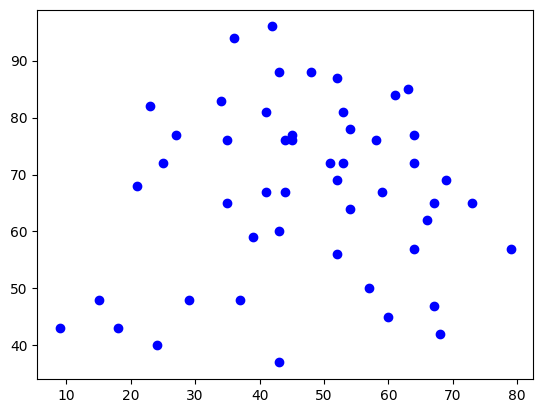

In [84]:
import random

random_seed = 1
data_freq = 50
# data = data_arr[:data_freq, :]
random.seed(random_seed)
indices = random.sample(range(data_arr.shape[0]), data_freq)

data = data_arr[indices, :]

plt.plot(data[:, 0], data[:, 1], marker='o', linestyle=' ', color='blue', label='Bike Data')

In [85]:
def _1flat(p1, p2):
    '''
    Returns the m, c values from the eqn y = mx + c, which is the eqn of the line formed by joining points p1 and p2
    If p1 == p2, we return line with slope 1
    If p1_x == p2_x, m = None and c = x_intercept
    Otherwise, m = slope and c = y_intercept
    '''
    
    if (p2[0] == p1[0]):
        if (p2[1] == p1[1]):
            return 1, p1[1] - p1[0]
        
        return None, p1[0]
    
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = round(p1[1] - m*p1[0], 2)
    
    return round(m, 2), c

In [86]:
import math

def find_dist(pt, line):
    if line[0] == None:
        return math.fabs(pt[0] - line[1])
    
    numerator = math.fabs(line[0]*pt[0] - pt[1] + line[1])
    denominator = math.sqrt(1 + line[0]**2)
    
    return round(numerator/denominator, 7)

def find_min_dist(pt, F):
    F = list(F)
    min_dist = find_dist(pt, F[0])
    for line in F[1:]:
        cur_dist = find_dist(pt, line)
        min_dist = min(min_dist, cur_dist)
    
    return min_dist

In [87]:
import heapq

def Approx_k_j_Flats(P, k=2, j=1):
    C = 7
    
    t = 1
    Q = P
    F = set()
    
    while Q.shape[0] >= C*k*(j+1):
        S_len = int(np.log2((j+1)) + min(t, np.log2(np.log2(data_freq))))
        random.seed(2*t-1) # 1, 3, 5
        indx_S0 = random.sample(range(Q.shape[0]), S_len)
        random.seed(2*t)   # 2, 4, 6
        indx_S1 = random.sample(range(Q.shape[0]), S_len)
        
        F_ = set()
        for i in range(S_len):
            for j in range(S_len):
                F_.add(_1flat(Q[indx_S0[i]], Q[indx_S1[j]]))
        
        F.update(F_)
        
        min_dist_rec = [] # Contains lists [dist, indx] as elements where dist = min distance of Q[indx] from closest line
        Q_index = 0
        for pt in Q:
            min_dist_rec.append((-1*find_min_dist(pt, F_), Q_index))
            Q_index += 1
        
        heapq.heapify(min_dist_rec)
        
        Q_ = []
        for i in range(Q.shape[0]//2):
            Q_.append(Q[heapq.heappop(min_dist_rec)[1]])
        
        Q = np.array(Q_)
        t += 1
    
    return Q, F.copy()

In [50]:
# test

C = 1

k=2
j=1
t = 1
Q = data
F = set()

S_len = int(2 + np.log2(k*(j+1)) + min(t, np.log2(np.log2(data_freq))))
indx_S0 = random.sample(range(Q.shape[0]), S_len)
indx_S1 = random.sample(range(Q.shape[0]), S_len)

F_ = set()
for i in range(S_len):
    for j in range(S_len):
        F_.add(_1flat(Q[indx_S0[i]], Q[indx_S1[j]]))



25
{(1, 40), (-0.83, 101.17), (4.0, -104.0), (0.5, 53.5), (-2.0, 166.0), (0.08, 80.28), (0.24, 76.48), (-0.08, 70.15), (0.43, 49.17), (-0.5, 112.0), (-8.0, 589.0), (2.25, -25.25), (-0.2, 97.6), (0.0, 77.0), (-0.55, 101.55), (3.0, -56.0), (3.67, -88.0), (-1.21, 146.11), (0.92, 60.77), (-0.94, 127.68), (-0.61, 115.86), (-0.69, 121.0), (-5.0, 400.0), (None, 45), (-0.23, 87.23)}


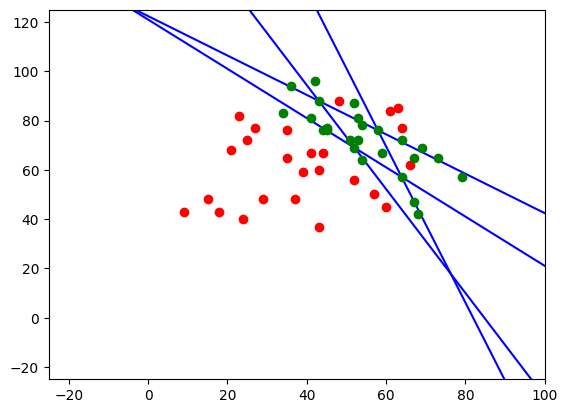

In [88]:
Q_2, F_2 = Approx_k_j_Flats(data)
F_2 = list(F_2)

plt.plot(Q_2[:, 0], Q_2[:, 1], marker='o', linestyle=' ', color='red', label='Bike Data')
for line in F_2:
    x1, y1, x2, y2 = 0, line[1], -line[1]/line[0], 0
#     plt.plot([0, -line[1]/line[0]], [line[1], 0], linestyle='-', color='blue')
    x = np.linspace(min(x1, x2) - 100, max(x1, x2) + 100, 100)
    y = ((y2 - y1) / (x2 - x1)) * (x - x1) + y1
    plt.plot(x, y, linestyle='-', color='blue')

data_view = data.view([('', data.dtype)] * data.shape[1])
Q_2_view = Q_2.view([('', Q_2.dtype)] * Q_2.shape[1])

Q_3 = np.setdiff1d(data_view, Q_2_view).view(data.dtype).reshape(-1, data.shape[1])

# mask = ~np.isin(data, Q_2)
# Q_3 = data[mask]
# print(len(Q_3))

plt.plot(Q_3[:, 0], Q_3[:, 1], marker='o', linestyle=' ', color='green')
plt.xlim(-25, 100)
plt.ylim(-25, 125)
plt.show()